# Melody phrase similarity in Carnatic and Hindustani music

This task is about identifying the similar melodic phrases in Carnatic and Hindustiani music. Melodic phrases are very 
characteristic for the Ragas of those traditions, thus even the same melodic phrases (e.g. La-Do-Sol in western 
notation) will be intonated and sang differently. The main goal is for the computed similarity using MIR methods to be 
representative of the domain knowledge coming from the musicological perspective

The dataset that we will be using for this task is the [Saraga dataset](https://zenodo.org/record/1256127) that is 
available in [Dunya](https://dunya.compmusic.upf.edu/) - the platform for exploration the music from different cultures 
that is one of results from the [CompMusic](https://compmusic.upf.edu/) project.

## 1. Dowloading the data
At ISMIR2018 there was a tutorial about MIR for music from non-western traditions, and there is very handy 
[notebook](https://github.com/MTG/Ismir2018TutorialNotebooks/blob/master/notebooks/downloadAllSARAGAContent.ipynb) that
allows to download the audio and annotations for Saraga dataset from Dunya. We also provide already downloaded data 
[here](https://drive.google.com/file/d/1PbLCNusMiUWYjQDn6S0pctkiJ_al2DvR/view?usp=sharing). Put the data into `data` folder in the root of this repository (or somewhere else, and update `config.py` accordingly).

## 2. Looking at the data
This code segment is based on another 
[notebook](https://github.com/MTG/Ismir2018TutorialNotebooks/blob/master/notebooks/visualizeAnnotations.ipynb) 
from ISMIR2018 tutorial that allows you to visualize all annotations, but we are only interested in melodic segments

In [14]:
import essentia.standard as ess
import numpy as np
import IPython
import json
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
# from fastdtw import fastdtw
import commons
import importlib

If you change repository files, run these line to reload

In [1]:
importlib.reload(commons)
importlib.reload(commons.config)

NameError: name 'importlib' is not defined

### Get the list of all recordings

In [17]:
traditions = ['carnatic', 'hindustani']
file_list = {tradition: commons.get_track_list(tradition) for tradition in traditions}

In [22]:
file_list['carnatic']

array(['Akkarai Sisters - Apparama Bhakti',
       'Akkarai Sisters - Brova Barama',
       'Akkarai Sisters - Geeta Nayakan',
       'Akkarai Sisters - Karunimpa Idi',
       'Akkarai Sisters - Koti Janmani',
       'Akkarai Sisters - Manadirkkugandhadu',
       'Akkarai Sisters - Pavamana Suthudu Mangalam',
       'Akkarai Sisters - Shankari Shankuru',
       'Akkarai Sisters - Siddhi Vinayakam',
       'Akkarai Sisters - Thillana Pahadi',
       'Ashwath Narayanan - Angakaram',
       'Ashwath Narayanan - Aparadhamula', 'Ashwath Narayanan - Eranapai',
       'Ashwath Narayanan - Evarura', 'Ashwath Narayanan - Marubari',
       'Ashwath Narayanan - Parama Purusham',
       'Ashwath Narayanan - Sadabalarupapi Shlokam',
       'Ashwath Narayanan - Samajavarada',
       'Ashwath Narayanan - Thillana Purnachandrika',
       'Chaitra Sairam - Anandaamrutakarshini',
       'Chaitra Sairam - Ardhanareeshwaram',
       'Chaitra Sairam - Gange Maampahi',
       'Chaitra Sairam - Govardhana Gi

### Look at one recording to understand the data

In [24]:
tradition = 'carnatic'
name = 'Akkarai Sisters - Apparama Bhakti'
audio, metadata, phrases = commons.load_track(tradition, name)
print("Raga: {}".format(metadata['raaga'][0]['common_name']))
collated_phrases = commons.collate_phrases(phrases)

Raga: kamavardani


In [31]:
data = {}
total_phrases = 0
for filename in file_list['carnatic']:
    try:
        audio, metadata, phrases = commons.load_track(tradition, filename)
    except ValueError:
        continue
    raga = metadata['raaga'][0]['common_name']
    data[raga] = commons.collate_phrases
    total_phrases += len(phrases)
    print(len(phrases))
print(total_phrases)

5
5
5
10
4
3
21
3


/Users/sapphire/UPF/mipfs-saraga/commons.py:39: UserWarning: loadtxt: Empty input file: "/Volumes/Onyx/UPF/data/carnatic/Akkarai Sisters - Thillana Pahadi.mphrases-manual.txt"
  'formats': ('f4', 'i4', 'f4', 'S32')})


0
11
6


TypeError: len() of unsized object

In [25]:
melodies = []
labels = []
audios = []
for phrase, segments in collated_phrases.items():
    print(phrase.decode())
    for (start, end) in segments:
        labels.append(phrase.decode())
        audio_segment = audio[start:end]
        audios.append(audio_segment)
        melody, confidence = commons.extract_pitch(audio_segment)
        melodies.append(melody)
        commons.display_audio(audio_segment)

pmgmpmgrsnrg


sndnmd


gmpdpdndpmr


sdpm


### Understanding annotations

Svara or swara is a Sanskrit word that connotes a note in the successive steps of the octave. More comprehensively, it is the ancient Indian concept about the complete dimension of musical pitch. 

The seven notes of the musical scale in Indian classical music are shadja (षड्ज), rishabha (ऋषभ), gandhara (गान्धार), madhyama (मध्यम), panchama (पञ्चम), dhaivata (धैवत) and nishada (निषाद). These seven swaras are shortened to **Sa, Ri (Carnatic) or Re (Hindustani), Ga, Ma, Pa, Dha, and Ni**. Collectively these notes are known as the sargam (the word is an acronym of the consonants of the first four swaras). Sargam is the Indian equivalent to solfege, a technique for the teaching of sight-singing. The tone **Sa** is, as in Western moveable-Do solfège, the tonic of a piece or scale.

This excrept is taken from [Wikipedia](https://en.wikipedia.org/wiki/Svara), there will be more in-depth talk about indian music on Thursday.

For our purposes those swaras are shortened to the first consonant: Sa -> s, Ri, Re -> r, etc. The annotation of the phrases denote the sequence, for example the first one: **ndmdnsndn** means the sequence of **Ni Dha Ma Dha Ni Sa Ni Dha Ni** which translates to **Si La Fa La Si Do Si La Si**.

### Visualising phrases

Let's extract the pitch and see how different the phrases are numerically

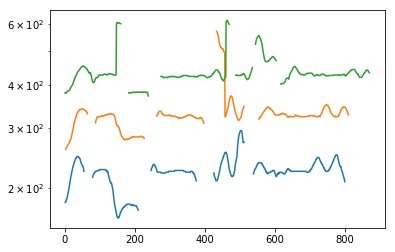

In [12]:
for i in np.arange(3):
    plt.semilogy(commons.get_plot_pitch(melodies[i]) + i*100)

### Computing similarity

There are several ways to compute similarity of the melodic phrases from a computational perspective. Very naive approach would be to use [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping). 

In [24]:
n = len(melodies)
distances = np.zeros(shape=(n,n))
for i in np.arange(n):
    for j in np.arange(i):
        distance, path = fastdtw(melodies[i], melodies[j], dist=dist.euclidean)
        distances[i][j] = distances[j][i] = distance

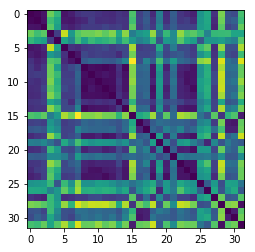

In [25]:
plt.imshow(distances)

As the melodic phrases with the same annotations are close together in the sequence, we can see those dark squares that mean higher similarity withing those areas.

However there are a lot of problems with this naive approach:
- Using Hz scale instead of cents
- No pre-processing before similarity computation
- etc.

### Resources

[Sankalp Gulati](https://compmusic.upf.edu/node/304) had been researching the melodic similarity in indian music, and has a lot of publications, results and code. His [Github](https://github.com/sankalpg) and [webpage](http://www.sankalpgulati.in)